## Jeremy Kazimer
#### 5018-1732
#### Assignment #2

---

As always, import statements:

In [37]:
from numpy import array, pi, sum, zeros, add, arange, meshgrid, max, polyfit, log, exp
from matplotlib import pyplot as plt

**(A.)** _Jacobi solution_

For this part of the assignment, the purpose was to apply the Jacobi method (as defined in the slides) for a Poisson dipole parallel to the x-axis with the constraints:
* $d = 0.5$ (spacing between particles) 
* $L = 1.0$ (length of the square box)
* $q = 10.0$ (charge of the particle)

As such, we can reuse the Poisson class from the examples, removing unused elements:

In [2]:
class Poisson :
    def __init__ (self, L, rho_init, method, calcError = True):
        
        # Spacing
        self.L = L                    # number of interior points in x and y
        self.omega = 2/(1 + pi/L)          # over-relaxation parameter for L = 50
        self.N = L + 2                # interior plus two boundary points
        N = self.N
        self.h = 1.0 / (L + 1)        # lattice spacing assuming size in x and y = 1
        
        # Potential
        self.V = zeros((N,  N))   # potential to be found
        self.VNew = zeros((N, N))# new potential after each step
        
        # Density
        self.rho = array(rho_init)
        
        # Method
        self.method = method      

    def __call__(self):
        return getattr(self, self.method)()

    def update(self):
        self.V[:,:] = self.VNew[:,:]

    def Jacobi(self) :
        '''
        Jacobi algorithm for a single iterative step
        '''
        self.VNew = self.JacStep(self.VNew, self.V, self.h, self.rho)
        return self.update()

    def JacStep(self, u, v, h, rho):
        '''
        Jacobi algorithm on arbitrary inputs. Called once by "Jacobi".
        Called many times by "MultiGrid"
        '''
        u[1:-1,1:-1] = add.reduce([
            0.25*v[1:-1, 2:] ,
            0.25*v[1:-1, 0:-2],
            0.25*v[2:,   1:-1] ,
            0.25*v[0:-2, 1:-1] ,
            0.25*h**2 * rho[1:-1,1:-1]])
        
        return u

Then, the dipole for this particular problem would be set-up as such:

In [3]:
# L is arbitrary, since it is rescaled anyway.
L = 38

# Number of points.
N = L+2

# Charge
q = 10.0

# Center of lattice.  Consider arrays in Python start at zero, so
# we must subtract 1.
i = N//2 - 1 

# x-location of points.  This works because we assume L = 1 and
# each point is 0.25 (1/4th of 1) from the center.
# This only works well if L is divsible by both 2 and 4.
j = N//4 - 1

# Step size.
h = 1/(L + 1)

# Charge density
rho = zeros((N, N))
rho[i, j] = q/h**2
rho[i, i + j] = q/h**2

# Number of iterations for the Jacobi method.
nsteps = 1000

# The Poisson object.
p = Poisson(L, rho, 'Jacobi')

# Calculating V for each Jacobi iteration:
for step in arange(nsteps):
    p()

We can then plot the figure on both an `imshow` and a 3-D projection:

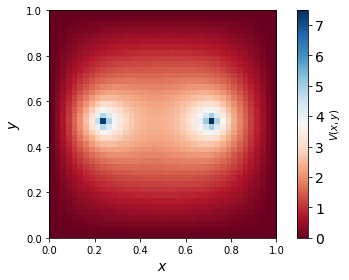

In [4]:
fig, ax = plt.subplots(1, 1)

I = ax.imshow(p.V, cmap = 'RdBu', extent = [0, 1, 0, 1])

ax.set_ylabel('$y$', fontsize = 14)
ax.set_xlabel('$x$', fontsize = 14)

cbar = fig.colorbar(I, label = '$V(x, y)$')
cbar.ax.tick_params(labelsize = 14)

fig.tight_layout();

Here, the color bar is indicative of the intensity of the potential.  As one would expect, the most potential exists at each particle and then between the two.  A further demonstration with a 3-D projection:

In [5]:
# This is fine because the box is symmetric.
# The code assumes symmetry so this isn't really
# a concern.
x = arange(0, p.h*(p.L + 2), p.h)
y = x

# A meshgrid, or the x and y values
# at each element of the lattice.
X, Y = meshgrid(x, y)

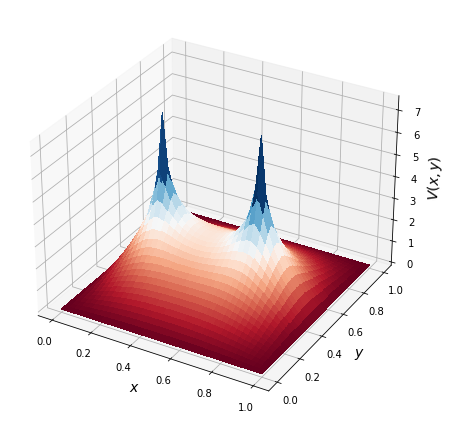

In [6]:
fig = plt.figure(1, figsize = (6, 6))

# Make a '3d' figure.
ax = fig.gca(projection='3d')

# Plot the surface.
surface = ax.plot_surface(X, Y, p.V, rstride = 1, cstride = 1, cmap='RdBu',
                        linewidth = 0, antialiased = False)


ax.set_xlabel('$x$', fontsize = 14)
ax.set_ylabel('$y$', fontsize = 14)
ax.set_zlabel('$V(x, y)$', fontsize = 14)

fig.tight_layout();

Ultimately this agrees with the above display.  This, however, gives it a bit of a more dynamic look such that the disparities in potential can be more easily displayed.  

Regardless, there are a few issues with this method.  Namely, that $V$ for the Jacobi is upper bounded by the value of $q$.  A plot of this can be seen below:

In [39]:
# Each step interval.
tsteps = arange(1, 21930)

# Storing the maximum potential as reference
max_V = zeros(tsteps.shape[0])

# We create a new Poisson object each time and store the max v after each step.
p = Poisson(L, rho, 'Jacobi')

# Calculating V for each Jacobi iteration:
for idx, step in enumerate(tsteps):
    p()
    
    # Storing it.
    max_V[idx] = max(p.V)

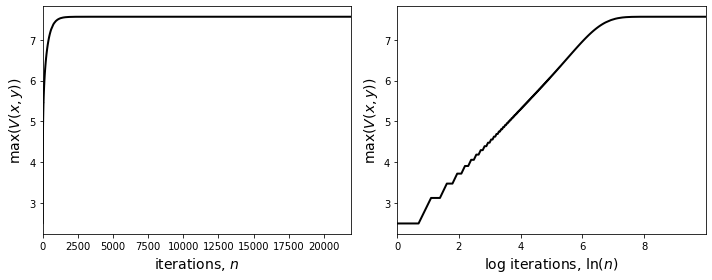

In [40]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))

axs[0].plot(tsteps, max_V, lw = 2, c = 'k')

axs[0].set_xlim(0, 21930)

axs[0].set_ylabel('max($V(x, y)$)', fontsize = 14)
axs[0].set_xlabel('iterations, $n$', fontsize = 14)

axs[1].plot(log(tsteps), max_V, lw = 2, c = 'k')

axs[1].set_xlim(0, log(21930))

axs[1].set_ylabel('max($V(x, y)$)', fontsize = 14)
axs[1].set_xlabel('log iterations, $\ln(n)$', fontsize = 14)

fig.tight_layout()

We can see that max($V(x,y)$) is logarithmically and asymptotically approaching the scalar value of $q$ as $n$ increases, until about after 1000 iterations.  Therefore, for infinitely large $n$, the theoretical value of $V(x, y)$ should be $10$.  In practice, it appears to be approximately $7.5$.  Even though the units don't match up, assume that there's some hidden variables such that it does.  Therefore, regardless of $h$, it should always approach $10$, since $h < 1$ always.  This may not seem important now, but it is later.  

Ultimately, it appears that the maximum value of the potential is agnostic to $h$.  Rather, $h$ is more-so important for how well-defined the distribution is in the sense that it determines the differential spacing.  It would follow that a smaller $h$ value would provide a steeper structure, whereas larger $h$ provides a vague sense of the structure.  However, in neither sense do they affect the maximum value of $V(x, y)$.  Truly, the most defined structure would come with effectively zero spacing, but it would not change the maximum, so to speak.

**(B.)** _theoretical solution_